In [2]:
import sys
sys.path.append('../')
from plot_config import *
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

In [3]:
# Simulation methods

def euler_sim(M, x0 ,dt, T, Perturbation=None):
    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    # If statements outside the loop for performance!
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            X[i+1] = X[i] + 1j * (M+Perturbation(t)) @ X[i] *dt
    else:
        for i, t in enumerate(t_range):
            X[i+1] = X[i] + 1j*dt*M @ X[i]

    return X

def rk4_sim(M, x0, dt, T, Perturbation=None):

    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            k1 = 1j * (M+Perturbation(t)) @ X[i]
            k2 = 1j * (M+Perturbation(t+dt/2)) @ (X[i] + k1*dt/2)
            k3 = 1j * (M+Perturbation(t+dt/2)) @ (X[i] + k2*dt/2)
            k4 = 1j * (M+Perturbation(t+dt)) @ (X[i] + k3*dt)
            X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    else:
        for i, t in enumerate(t_range):
            k1 = 1j * M @ X[i]
            k2 = 1j * M @ (X[i] + k1*dt/2)
            k3 = 1j * M @ (X[i] + k2*dt/2)
            k4 = 1j * M @ (X[i] + k3*dt)
            X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

def implicit_euler_sim(M,x0,dt , T, Perturbation = None):

    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            X[i+1] = np.linalg.solve(np.eye(M.shape[0])-1j*dt*(M+Perturbation(t)), X[i])
    else:
        for i, t in enumerate(t_range):
            X[i+1] = np.linalg.solve(np.eye(M.shape[0])-1j*dt*M, X[i])


    return X

In [4]:
# Definitions of the laser -> coupling of the states

def intensity(t):
    return 2*E/(tau_p * np.pi* w_0**2)*2**(-4*((t-t_0)/(tau_p))**2)

def Omega_if(t, mu):
    return mu*np.sqrt(intensity(t))

In [5]:
# Constants

from scipy.constants import physical_constants as pc
aut = pc['atomic unit of time'][0]
E = 200*1e-6 / pc['atomic unit of energy'][0] #uJ


tau_p = 5*1e-9 / aut #ns
t_0 = 10*1e-9 / aut #ns
w_0 = 0.5*1e-3 / pc['atomic unit of length'][0] #mm

mu_i_phi = np.sqrt(0.1)*0.15324673 # au
mu_i_psi = np.sqrt(0.2)*0.09692173 #au

E_i_phi = 5000*1e2 * pc["atomic unit of length"][0]  #cm^-1
E_i_psi = 5000*1e2 * pc["atomic unit of length"][0] #cm^-1
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] #cm^-1

x0 = np.array([1, 0, 0])
dt = 0.005e-9/aut
T = 50e-9/aut

omega_range = np.linspace(0.7*E_i_phi, 1.1*E_i_phi, 14)
num_threads_max = 7

PROJECT_DIR = os.path.dirname(os.path.abspath(''))
X_cache_dir = os.path.join(PROJECT_DIR, 'task3', 'x_cache')
os.makedirs(X_cache_dir, exist_ok=True)


In [6]:
import h5py

def calc_dissoc_yield(omega):
    # Check if the file is already computed
    if os.path.isfile(os.path.join(X_cache_dir, f'X_{str(omega*1e10)}_dt_{round(dt)}.h5')):
        with h5py.File(os.path.join(X_cache_dir, f'X_{str(omega*1e10)}_dt_{round(dt)}.h5'), 'r') as hf:
            X = hf['X'][:]
        dissoc_yield = 1 - np.max(np.abs(X[-10000:-1,0])**2)
        print(f'Loaded from cache: omega = {omega}, dissoc_yield = {dissoc_yield}')
        return omega, dissoc_yield

    E_i = 0
    E_phi = E_i_phi - omega
    E_psi = E_i_psi - omega + 1j* Gamma_diss/2
    g_phipsi = 0

    # laser
    laser = lambda t: np.array(
        [
            [0, np.conjugate(Omega_if(t,mu_i_phi))/2, np.conjugate(Omega_if(t,mu_i_psi))/2],
            [Omega_if(t,mu_i_phi)/2, 0, 0],
            [Omega_if(t,mu_i_psi)/2, 0, 0],
        ]
    )

    M = np.array(
        [
            [E_i, 0,0],
            [0, E_phi, np.conjugate(g_phipsi)/2],
            [0, g_phipsi/2, E_psi],
        ]
    )

    Perturbation = laser

    X = rk4_sim(M, x0, dt, T, Perturbation)

    # Save with HDF5 (better than .txt for large arrays)
    with h5py.File(os.path.join(X_cache_dir, f'X_{str(omega*1e10)}_dt_{round(dt)}.h5'), 'w') as hf:
        hf.create_dataset('X', data=X)
    dissoc_yield = 1 - np.max(np.abs(X[-10000:-1,0])**2)
    return omega, dissoc_yield


def worker(omega, result_dict):
    result_dict[omega] = calc_dissoc_yield(omega)


In [7]:
# TODO: Remove me, just to update constants
x0 = np.array([1, 0, 0])
dt = 0.0005e-9 / aut
T = 50e-9 / aut

omega_range = np.linspace(0.9*E_i_phi, 1.1*E_i_phi, 35)
num_threads_max = 7

In [9]:
# Parallel processing

dissoc_yields = {}

with ProcessPoolExecutor(max_workers=num_threads_max) as executor:
    futures = {executor.submit(calc_dissoc_yield, omega): omega for omega in omega_range}
    for future in as_completed(futures):
        omega, dissoc_yield = future.result()
        dissoc_yields[omega] = dissoc_yield
        print(f'Finished for omega={omega}')



Loaded from cache: omega = 1.712043917627353e-05, dissoc_yield = 0.21219250460524353Loaded from cache: omega = 1.556403561479412e-05, dissoc_yield = 0.16224500580129597Loaded from cache: omega = 1.4007632053314705e-05, dissoc_yield = 0.12755386931849155Loaded from cache: omega = 1.3229430272575e-05, dissoc_yield = 0.11412495585589222


Loaded from cache: omega = 1.6342237395533824e-05, dissoc_yield = 0.18484747782350108Loaded from cache: omega = 1.4785833834054412e-05, dissoc_yield = 0.14339931341699863Loaded from cache: omega = 1.7898640957013238e-05, dissoc_yield = 0.24556717597440592

Loaded from cache: omega = 1.8676842737752943e-05, dissoc_yield = 0.2866447482818246Loaded from cache: omega = 1.9455044518492648e-05, dissoc_yield = 0.3375644540729036Loaded from cache: omega = 2.0233246299232353e-05, dissoc_yield = 0.4009471498880832



Loaded from cache: omega = 2.1789649860711767e-05, dissoc_yield = 0.5760822591054189
Loaded from cache: omega = 2.2567851641451472e-05, dissoc_yield 

In [ ]:
# t = np.linspace(0, T, int(T/dt))
# print(X.shape)
# plot_range = [999000, 999200]
# plt.plot(t[plot_range[0]:plot_range[1]], np.real(X[:, 0][plot_range[0]:plot_range[1]]), label="Real")
# plt.plot(t[plot_range[0]:plot_range[1]], np.imag(X[:, 0][plot_range[0]:plot_range[1]]), label="Imag")
# plt.show()

Finished successfully


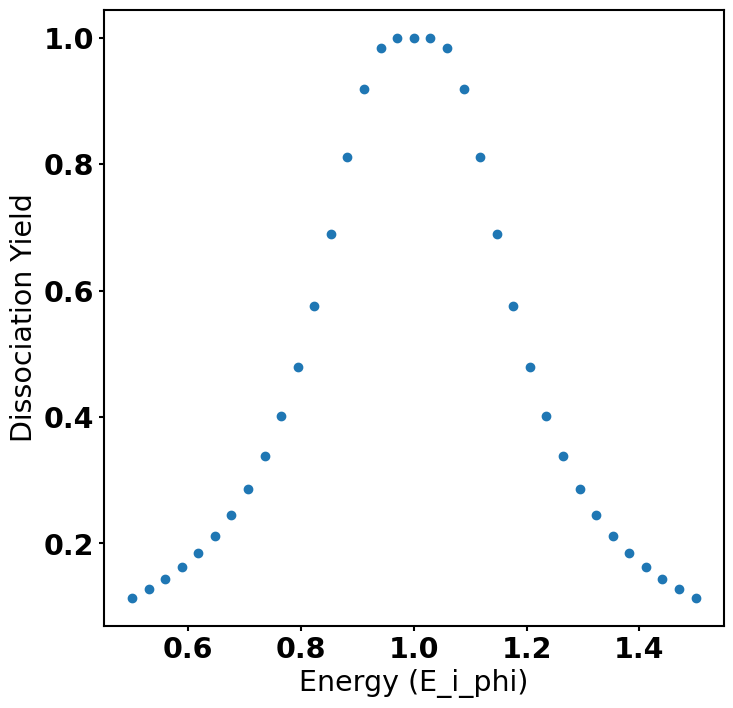

In [12]:
# Plot the results
plt.plot([float(omega)/E_i_phi for omega in dissoc_yields.keys()], list(dissoc_yields.values()), ls='', marker='o')
plt.savefig(os.path.join(PROJECT_DIR, 'fano.png'))
plt.xlabel("Energy (E_i_phi)")
plt.ylabel("Dissociation Yield")
print('Finished successfully')